# A. Input shape NxN,  N=5

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, f1_score, classification_report

Using TensorFlow backend.


In [4]:
fracture_data_1 = loadmat('fracture_sample.mat')['frac1unit16']
fracture_data_2 = loadmat('fracture_sample.mat')['frac2unit16']
fracture_data_01 = loadmat('fracture_sample.mat')['nonfrac1unit16']
fracture_data_02 = loadmat('fracture_sample.mat')['nonfrac2unit16']

In [5]:
#predicted_data = np.array(fracture_data > 0, dtype = int)
predicted_data_1 = loadmat('fracture_sample.mat')['frac1_binary']
predicted_data_2 = loadmat('fracture_sample.mat')['frac2_binary']
predicted_data_01 = np.zeros(fracture_data_01.shape)
predicted_data_02 = np.zeros(fracture_data_02.shape)

In [6]:
N=5
np.arange(0, fracture_data_1.shape[1]-N)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [7]:
N=5
fracture_data_1 = np.array([fracture_data_1[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_1.shape[1]-N) 
              for y in np.arange(0, fracture_data_1.shape[0]-N)])

predicted_data_1 = np.array([predicted_data_1[y,x] 
              for x in np.arange(0, predicted_data_1.shape[1]-N) 
              for y in np.arange(0, predicted_data_1.shape[0]-N)])

fracture_data_2 = np.array([fracture_data_2[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_2.shape[1]-N) 
              for y in np.arange(0, fracture_data_2.shape[0]-N)])

predicted_data_2 = np.array([predicted_data_2[y,x]  
              for x in np.arange(0, predicted_data_2.shape[1]-N) 
              for y in np.arange(0, predicted_data_2.shape[0]-N)])

fracture_data_01 = np.array([fracture_data_01[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_01.shape[1]-N) 
              for y in np.arange(0, fracture_data_01.shape[0]-N)])

predicted_data_01 = np.array([predicted_data_01[y,x] 
              for x in np.arange(0, predicted_data_01.shape[1]-N) 
              for y in np.arange(0, predicted_data_01.shape[0]-N)])

fracture_data_02 = np.array([fracture_data_02[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_02.shape[1]-N) 
              for y in np.arange(0, fracture_data_02.shape[0]-N)])

predicted_data_02 = np.array([predicted_data_02[y,x] 
              for x in np.arange(0, predicted_data_02.shape[1]-N) 
              for y in np.arange(0, predicted_data_02.shape[0]-N)])


In [8]:
train_split = int(fracture_data_1.shape[0]/2)
valid_split = int(fracture_data_1.shape[0]*3/4)

fracture_train = np.concatenate((fracture_data_1[:train_split,...],
                           fracture_data_2[:train_split,...],
                           fracture_data_01[:train_split,...],
                           fracture_data_02[:train_split,...]), axis = 0)
fracture_valid = np.concatenate((fracture_data_1[train_split:valid_split,...],
                           fracture_data_2[train_split:valid_split,...],
                           fracture_data_01[train_split:valid_split,...],
                           fracture_data_02[train_split:valid_split,...]), axis = 0)
fracture_test =  np.concatenate((fracture_data_1[valid_split:,...],
                           fracture_data_2[valid_split:,...],
                           fracture_data_01[valid_split:,...],
                           fracture_data_02[valid_split:,...]), axis = 0)

predicted_train = np.concatenate((predicted_data_1[:train_split,...],
                            predicted_data_2[:train_split,...],
                            predicted_data_01[:train_split,...],
                            predicted_data_02[:train_split,...]), axis = 0)
predicted_valid = np.concatenate((predicted_data_1[train_split:valid_split,...],
                            predicted_data_2[train_split:valid_split,...],
                            predicted_data_01[train_split:valid_split,...],
                            predicted_data_02[train_split:valid_split,...]), axis = 0)
predicted_test =  np.concatenate((predicted_data_1[valid_split:,...],
                            predicted_data_2[valid_split:,...],
                            predicted_data_01[valid_split:,...],
                            predicted_data_02[valid_split:,...]), axis = 0)

In [9]:
# Simple Neural Network

train_x = np.stack([fracture_train], axis = 3)
train_y = predicted_train

train_x_mean, train_x_std = np.mean(train_x), np.std(train_x)

train_x = (train_x - train_x_mean) / train_x_std

valid_x = np.stack([fracture_valid], axis = 3)
valid_y = predicted_valid

valid_x = (valid_x - train_x_mean) / train_x_std

test_x = np.stack([fracture_test], axis = 3)
test_y = predicted_test

test_x = (test_x - train_x_mean) / train_x_std

In [10]:
print(fracture_train.shape)
print(fracture_valid.shape)
print(fracture_test.shape)
print(train_x.shape)
print(train_y.shape)

(111392, 5, 5)
(55696, 5, 5)
(55696, 5, 5)
(111392, 5, 5, 1)
(111392,)


## A1. model 1: Deep NN

In [11]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
#model.add(Conv2D(16, kernel_size = (5,5), data_format = 'channels_last',
#                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
#model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size = (3,3)))
#model.add(Activation('relu'))

model.add(Flatten(input_shape = train_x.shape[1:]))
#model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dens

In [15]:
test_y_predict = model.predict(test_x)


In [16]:
#test_y_predict = [x[0] for x in test_y_predict]
test_y_predict = np.array(test_y_predict)

In [17]:
test_y[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
test_y_predict[:10]

array([[0.00079173],
       [0.00102198],
       [0.00104749],
       [0.0008432 ],
       [0.0010266 ],
       [0.0008719 ],
       [0.00103498],
       [0.00112239],
       [0.000635  ],
       [0.00053144]], dtype=float32)

In [19]:
test_x.shape

(55696, 5, 5, 1)

In [20]:
confusion_matrix(test_y, (test_y_predict> 0.5))

array([[49385,   951],
       [ 3416,  1944]])

In [21]:
f1_score(test_y, (test_y_predict > 0.5))

0.47098728043609933

In [23]:
print(classification_report(test_y, (test_y_predict > 0.27)))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     50336
         1.0       0.55      0.54      0.55      5360

   micro avg       0.91      0.91      0.91     55696
   macro avg       0.75      0.75      0.75     55696
weighted avg       0.91      0.91      0.91     55696



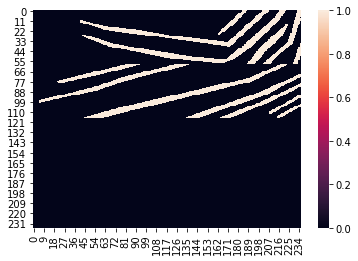

In [22]:
test_y_2d = test_y[0:].reshape(236,236)
test_y_predict_2d = test_y_predict[0:].reshape(236,236)
sns.heatmap(test_y_2d)

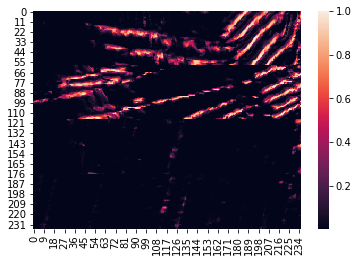

In [23]:
sns.heatmap(test_y_predict_2d)

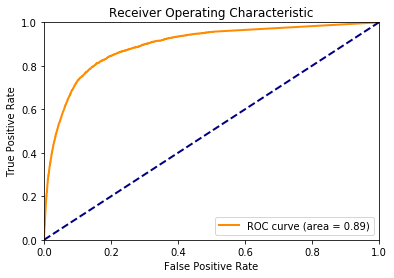

0.8943134746444195


In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

## A2. model 2: 1 Convolutional filter + Deep NN

In [11]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
model.add(Conv2D(16, kernel_size = (3,3), data_format = 'channels_last',
                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size = (3,3)))
#model.add(Activation('relu'))

#model.add(Flatten(input_shape = train_x.shape[1:]))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 16)          160       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4640      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dens

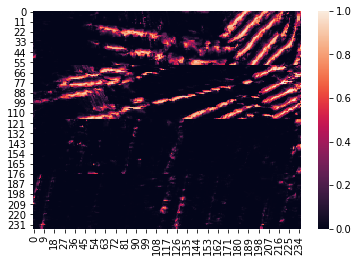

In [12]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[0:].reshape(236,236)
test_y_predict_2d = test_y_predict[0:].reshape(236,236)
sns.heatmap(test_y_predict_2d)

In [15]:
print(classification_report(test_y, (test_y_predict > 0.3)))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     50336
         1.0       0.55      0.56      0.56      5360

   micro avg       0.91      0.91      0.91     55696
   macro avg       0.75      0.76      0.75     55696
weighted avg       0.91      0.91      0.91     55696



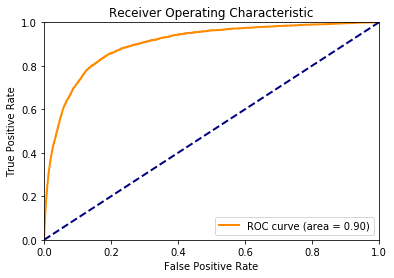

0.901374713418366


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

## A3. model3: 2 Convolutional filter + Deep NN

In [11]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
model.add(Conv2D(16, kernel_size = (3,3), data_format = 'channels_last',
                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation('relu'))

#model.add(Flatten(input_shape = train_x.shape[1:]))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 16)          160       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dens

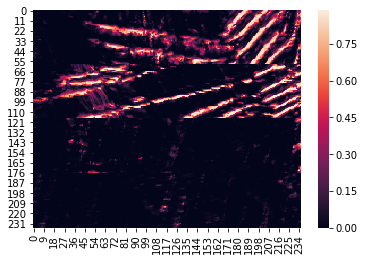

In [12]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[0:].reshape(236,236)
test_y_predict_2d = test_y_predict[0:].reshape(236,236)
sns.heatmap(test_y_predict_2d)

In [15]:
print(classification_report(test_y, (test_y_predict > 0.3)))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     50336
         1.0       0.58      0.57      0.58      5360

   micro avg       0.92      0.92      0.92     55696
   macro avg       0.77      0.76      0.77     55696
weighted avg       0.92      0.92      0.92     55696



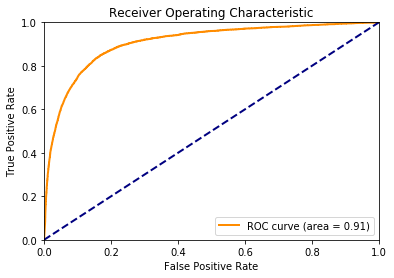

0.9064840725548198


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

# B. Input shape NxN, N=10

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, f1_score, classification_report

Using TensorFlow backend.


In [4]:
fracture_data_1 = loadmat('fracture_sample.mat')['frac1unit16']
fracture_data_2 = loadmat('fracture_sample.mat')['frac2unit16']
fracture_data_01 = loadmat('fracture_sample.mat')['nonfrac1unit16']
fracture_data_02 = loadmat('fracture_sample.mat')['nonfrac2unit16']

In [5]:
#predicted_data = np.array(fracture_data > 0, dtype = int)
predicted_data_1 = loadmat('fracture_sample.mat')['frac1_binary']
predicted_data_2 = loadmat('fracture_sample.mat')['frac2_binary']
predicted_data_01 = np.zeros(fracture_data_01.shape)
predicted_data_02 = np.zeros(fracture_data_02.shape)

In [6]:
N=10
np.arange(0, fracture_data_1.shape[1]-N)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [7]:
N=10
fracture_data_1 = np.array([fracture_data_1[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_1.shape[1]-N) 
              for y in np.arange(0, fracture_data_1.shape[0]-N)])

predicted_data_1 = np.array([predicted_data_1[y,x] 
              for x in np.arange(0, predicted_data_1.shape[1]-N) 
              for y in np.arange(0, predicted_data_1.shape[0]-N)])

fracture_data_2 = np.array([fracture_data_2[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_2.shape[1]-N) 
              for y in np.arange(0, fracture_data_2.shape[0]-N)])

predicted_data_2 = np.array([predicted_data_2[y,x]  
              for x in np.arange(0, predicted_data_2.shape[1]-N) 
              for y in np.arange(0, predicted_data_2.shape[0]-N)])

fracture_data_01 = np.array([fracture_data_01[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_01.shape[1]-N) 
              for y in np.arange(0, fracture_data_01.shape[0]-N)])

predicted_data_01 = np.array([predicted_data_01[y,x] 
              for x in np.arange(0, predicted_data_01.shape[1]-N) 
              for y in np.arange(0, predicted_data_01.shape[0]-N)])

fracture_data_02 = np.array([fracture_data_02[(y-0):(y+N), (x-0):(x+N)] 
              for x in np.arange(0, fracture_data_02.shape[1]-N) 
              for y in np.arange(0, fracture_data_02.shape[0]-N)])

predicted_data_02 = np.array([predicted_data_02[y,x] 
              for x in np.arange(0, predicted_data_02.shape[1]-N) 
              for y in np.arange(0, predicted_data_02.shape[0]-N)])

In [8]:
train_split = int(fracture_data_1.shape[0]/2)
valid_split = int(fracture_data_1.shape[0]*3/4)

fracture_train = np.concatenate((fracture_data_1[:train_split,...],
                           fracture_data_2[:train_split,...],
                           fracture_data_01[:train_split,...],
                           fracture_data_02[:train_split,...]), axis = 0)
fracture_valid = np.concatenate((fracture_data_1[train_split:valid_split,...],
                           fracture_data_2[train_split:valid_split,...],
                           fracture_data_01[train_split:valid_split,...],
                           fracture_data_02[train_split:valid_split,...]), axis = 0)
fracture_test =  np.concatenate((fracture_data_1[valid_split:,...],
                           fracture_data_2[valid_split:,...],
                           fracture_data_01[valid_split:,...],
                           fracture_data_02[valid_split:,...]), axis = 0)

predicted_train = np.concatenate((predicted_data_1[:train_split,...],
                            predicted_data_2[:train_split,...],
                            predicted_data_01[:train_split,...],
                            predicted_data_02[:train_split,...]), axis = 0)
predicted_valid = np.concatenate((predicted_data_1[train_split:valid_split,...],
                            predicted_data_2[train_split:valid_split,...],
                            predicted_data_01[train_split:valid_split,...],
                            predicted_data_02[train_split:valid_split,...]), axis = 0)
predicted_test =  np.concatenate((predicted_data_1[valid_split:,...],
                            predicted_data_2[valid_split:,...],
                            predicted_data_01[valid_split:,...],
                            predicted_data_02[valid_split:,...]), axis = 0)

In [9]:
# Simple Neural Network

train_x = np.stack([fracture_train], axis = 3)
train_y = predicted_train

train_x_mean, train_x_std = np.mean(train_x), np.std(train_x)

train_x = (train_x - train_x_mean) / train_x_std

valid_x = np.stack([fracture_valid], axis = 3)
valid_y = predicted_valid

valid_x = (valid_x - train_x_mean) / train_x_std

test_x = np.stack([fracture_test], axis = 3)
test_y = predicted_test

test_x = (test_x - train_x_mean) / train_x_std

In [10]:
print(fracture_test.shape)

(53364, 10, 10)


##  B1. model 1: Deep NN

In [11]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
#model.add(Conv2D(16, kernel_size = (5,5), data_format = 'channels_last',
#                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
#model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size = (3,3)))
#model.add(Activation('relu'))

model.add(Flatten(input_shape = train_x.shape[1:]))
#model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dens

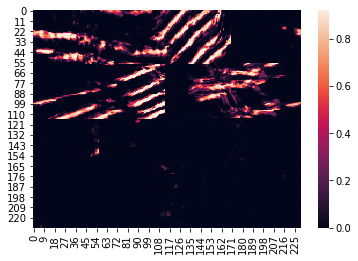

In [12]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[3:].reshape(231,231)
test_y_predict_2d = test_y_predict[3:].reshape(231,231)
sns.heatmap(test_y_predict_2d)

In [17]:
print(classification_report(test_y, (test_y_predict > 0.2)))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     48355
         1.0       0.48      0.50      0.49      5009

   micro avg       0.90      0.90      0.90     53364
   macro avg       0.72      0.72      0.72     53364
weighted avg       0.90      0.90      0.90     53364



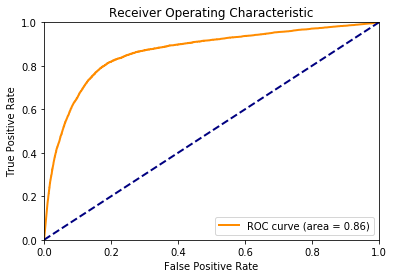

0.8642855082958008


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

## B2. model 2: 1 Convolutional filter + Deep NN

In [11]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
model.add(Conv2D(16, kernel_size = (3,3), data_format = 'channels_last',
                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size = (3,3)))
#model.add(Activation('relu'))

#model.add(Flatten(input_shape = train_x.shape[1:]))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 16)          160       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dens

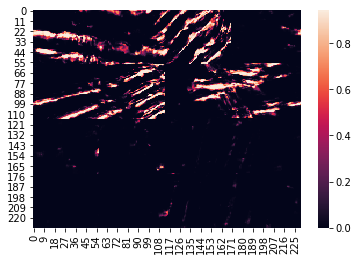

In [12]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[3:].reshape(231,231)
test_y_predict_2d = test_y_predict[3:].reshape(231,231)
sns.heatmap(test_y_predict_2d)

In [16]:
print(classification_report(test_y, (test_y_predict > 0.15)))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     48355
         1.0       0.48      0.47      0.47      5009

   micro avg       0.90      0.90      0.90     53364
   macro avg       0.71      0.71      0.71     53364
weighted avg       0.90      0.90      0.90     53364



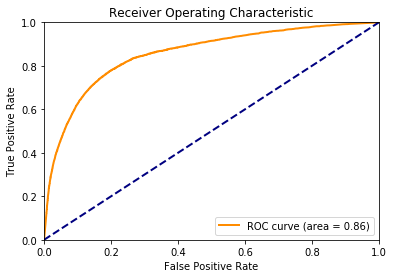

0.8557260048446763


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)

## B3. model 3: 2 Convolutional filter + Deep NN

In [11]:
batch_size = 16
epochs = 20

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

model = Sequential()
    
model.add(Conv2D(16, kernel_size = (3,3), data_format = 'channels_last',
                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation('relu'))

#model.add(Flatten(input_shape = train_x.shape[1:]))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(),
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y))#,
                    #callbacks = callback)#,
                    #class_weight=class_weights)

score = model.evaluate(test_x, test_y, verbose=0)
print(score)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 16)          160       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                36896     
_________________________________________________________________
dens

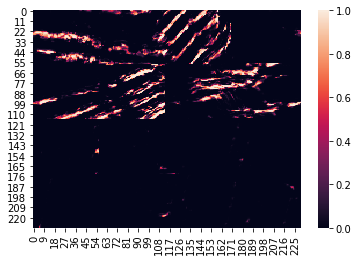

In [12]:
test_y_predict = model.predict(test_x)
test_y_predict = np.array(test_y_predict)
test_y_2d = test_y[3:].reshape(231,231)
test_y_predict_2d = test_y_predict[3:].reshape(231,231)
sns.heatmap(test_y_predict_2d)

In [18]:
print(classification_report(test_y, (test_y_predict > 0.07)))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     48355
         1.0       0.48      0.48      0.48      5009

   micro avg       0.90      0.90      0.90     53364
   macro avg       0.71      0.71      0.71     53364
weighted avg       0.90      0.90      0.90     53364



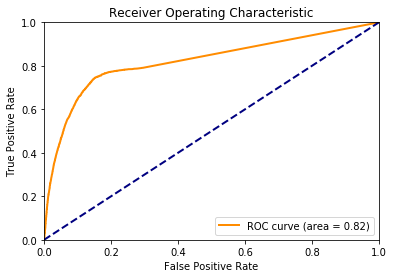

0.8211865751563429


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print(roc_auc)